<img src="https://avatars.githubusercontent.com/u/61354833" align="left" width="70" height="70">

Code by [TomMakesThings](https://github.com/TomMakesThings/Genome-Sequence-Analysis-HMM)

# **About**
A Hopfield network is a type of neural network in which all nodes are full connected. In this notebook, the Hopfield net is evaluated for pattern recognition. See the corresponding <a href="https://github.com/TomMakesThings/Hopfield-Network">GitHub repository here</a>.

# Imports

In [60]:
import numpy as np
import random
import math
import statistics
from matplotlib import pyplot as plt

# Seed for reproducability
random.seed(10)

# Pattern Creation
The functions below are for creating and visualising the patterns for the network to learn:

In [1]:
# Allows binary patterns to be visualised as a grid
def plotPatterns(patterns, num_row, num_col, new_shape = None,
                 subplot_titles = None, file = None):
    
    if (isinstance(new_shape, tuple)):
        patterns = [patterns[i].reshape(new_shape) for i in range(len(patterns))]
    
    # Create empty subplots
    fig, axes = plt.subplots(num_row, num_col, figsize = (1.5 * num_col, 2 * num_row))

    for i in range(len(patterns)):
        
        if (num_row == 1):
            if (num_col == 1):
                ax = axes
            else:
                ax = axes[i]
        else:
            ax = axes[i // num_col, i % num_col]
            
        # Check if stored in a dictionary
        if (isinstance(patterns, dict)):
            # Get the identifier from the dictionary
            key = list(patterns.keys())[i]
            
            # Plot the pattern
            ax.imshow(patterns[key], cmap = 'gray')
            ax.set_title(key)
        # Assume in array
        else:
            ax.imshow(patterns[i], cmap = 'gray')
            
            if not isinstance(subplot_titles, type(None)):
                ax.set_title(subplot_titles[i])

    # Hide x and y axis labels
    try:
        for ax in axes.flatten():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    except:
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        
    if not isinstance(file, type(None)):
        # Save the figure
        plt.savefig(file, bbox_inches = 'tight')
        
    # Display the plot
    plt.show()

In [98]:
# Convert from dictionary to form suitable for training Hopfield network
def convertPatterns(patterns):
    # Flattern matricies to 1D and convert to array
    patterns = [np.array(patterns[i].flatten())[0] for i in patterns.keys()]
    
    for i in range(len(patterns)):
        # Change 0s to -1s
        patterns[i][patterns[i] == 0] = -1
        
    return(patterns)

In [99]:
# Adds random noise to a pattern
def addNoise(patterns, noise_threshold = 1):
    noisy_patterns = np.copy(patterns)

    for i in range(len(noisy_patterns)):
        # Generate random noise from a normal distribution
        noise_locations = np.array([np.random.normal(0) > noise_threshold for j in range(len(noisy_patterns[0]))])

        for k in range(len(noise_locations)):
            # Check if to add noise
            if noise_locations[k] == True:
                # Add noise by flipping bits
                noisy_patterns[i][k] = 1 if (noisy_patterns[0][k] == -1) else -1
                
    return(noisy_patterns)

In [100]:
# Corrupts a pattern by keeping only the upper part
def hiddenPatterns(patterns, pattern_shape = (5,4), remaining = [2,2]):
    # Record each new pattern
    hidden_patterns = []

    for i in range(len(patterns)):
        # Reshape as a matrix
        pattern = np.reshape(patterns[i], pattern_shape)
        # Get the part to keep
        remaining_part = pattern[:remaining[0], :remaining[1]]
        # Create a blank pattern and add the conserved part
        hidden_pattern = np.ones_like(pattern)
        hidden_pattern[:remaining[0], :remaining[1]] = remaining_part
        # Reshape to 1D
        hidden_pattern = hidden_pattern.flatten()
        # Record the updated pattern
        hidden_patterns.append(hidden_pattern)
                
    return(hidden_patterns)

## Letter Patterns
The first training set consists of 4 × 5 binary patterns depicting the first eight letters of the alphabet.
Each pattern is flattened to one dimension giving a pattern size of 20. For testing, two types of corrupt patterns were derived for each letter by:
* Adding random noise
* Masking the lower half of the pattern

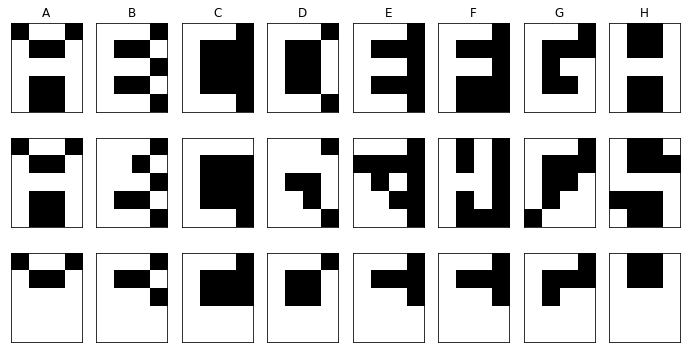

In [101]:
# Create letter patterns
letter_matrices = {'A' : np.matrix([[0,1,1,0],[1,0,0,1],[1,1,1,1],[1,0,0,1],[1,0,0,1]]),
                   'B' : np.matrix([[1,1,1,0],[1,0,0,1],[1,1,1,0],[1,0,0,1],[1,1,1,0]]),
                   'C' : np.matrix([[1,1,1,0],[1,0,0,0],[1,0,0,0],[1,0,0,0],[1,1,1,0]]),
                   'D' : np.matrix([[1,1,1,0],[1,0,0,1],[1,0,0,1],[1,0,0,1],[1,1,1,0]]),
                   'E' : np.matrix([[1,1,1,0],[1,0,0,0],[1,1,1,0],[1,0,0,0],[1,1,1,0]]),
                   'F' : np.matrix([[1,1,1,0],[1,0,0,0],[1,1,1,0],[1,0,0,0],[1,0,0,0]]),
                   'G' : np.matrix([[1,1,1,0],[1,0,0,0],[1,0,1,1],[1,0,0,1],[1,1,1,1]]),
                   'H' : np.matrix([[1,0,0,1],[1,0,0,1],[1,1,1,1],[1,0,0,1],[1,0,0,1]])}

# Convert from dictionary of matrices to array suitable for Hopfield network training
letter_patterns = convertPatterns(letter_matrices)
# Distort letters by adding noise
noisy_letter_patterns = addNoise(letter_patterns, noise_threshold = 1.1)
# Hide part of the letters
hidden_letter_patterns = hiddenPatterns(letter_patterns, remaining = [3,5])

# Plot the corrupted patterns
noisy_plot_data = dict(zip(letter_matrices.keys(),
                           [noisy_letter_patterns[i].reshape(5,4) for i in range(len(noisy_letter_patterns))]))
hidden_plot_data = dict(zip(letter_matrices.keys(),
                            [hidden_letter_patterns[i].reshape(5,4)for i in range(len(hidden_letter_patterns))]))

# View the letters
plotPatterns(list(letter_matrices.values()) + list(noisy_plot_data.values()) + list(hidden_plot_data.values()),
             num_row = 3, num_col = len(letter_matrices),
             subplot_titles = list(letter_matrices.keys()) + ["" for i in range(len(letter_matrices) * 2)],
             file = "Hopfield/letters.pdf")

## Shape Patterns
The second training set consists of 10 larger 10 × 10 patterns.

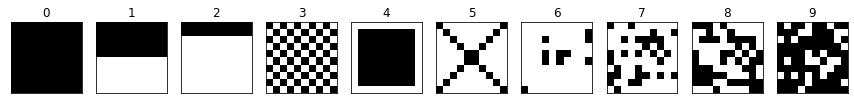

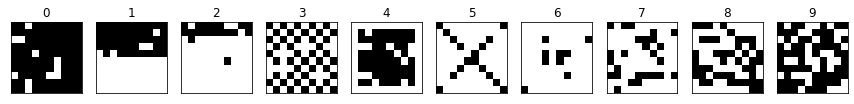

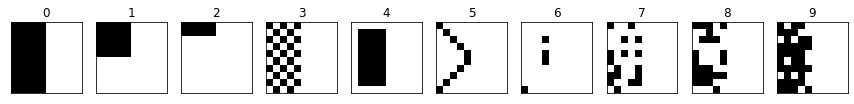

In [41]:
# Binary pattern dimensions
pattern_size = (10, 10)

# Calculate number of pixels based on pattern dimensions
n_pixels = 1
for i in pattern_size:
    n_pixels *= i
n_pixels

# Create pattern of all -1
binary_patterns = (np.ones(pattern_size) * -1).flatten()

# Pattern of half 1, half -1
half_pattern = np.ones(n_pixels).reshape(pattern_size)
half_pattern[:pattern_size[0] // 2] = -1
binary_patterns = np.vstack((binary_patterns, half_pattern.flatten()))

# Pattern of three quarters 1s
quarter_pattern = np.ones(n_pixels).reshape(pattern_size)
quarter_pattern[:pattern_size[0] // 4] = -1
binary_patterns = np.vstack((binary_patterns, quarter_pattern.flatten()))

# Pattern of -1 and 1 every other pixel
checkboard_pattern = np.indices(pattern_size).sum(axis = 0) % 2
for i in range(len(checkboard_pattern)):
    # Change 0s to -1s
    checkboard_pattern[i][checkboard_pattern[i] == 0] = -1
binary_patterns = np.vstack((binary_patterns, checkboard_pattern.flatten()))

# Pattern of edge 1 and middle -1
edge_ones = np.ones(pattern_size, dtype = int)
edge_ones[1:-1,1:-1] = -1
binary_patterns = np.vstack((binary_patterns, edge_ones.flatten()))

# X shape of -1
cross_pattern = np.ones(pattern_size)
np.fill_diagonal(cross_pattern, val = -1)
np.fill_diagonal(np.fliplr(cross_pattern), val = -1)
binary_patterns = np.vstack((binary_patterns, cross_pattern.flatten()))

# Create random patterns with different ratios of -1 and 1
pattern_probabilities = [[0.1, 0.9],
                         [0.3, 0.7],
                         [0.5, 0.5],
                         [0.7, 0.3]]

random_patterns = np.array([])
n_random = len(pattern_probabilities)

while len(random_patterns) < n_random:
    # Create a new randomly generated pattern
    new_random = np.array([np.random.choice([-1, 1], p = pattern_probabilities[len(random_patterns)])
                           for i in range(n_pixels)])
    # Check the pattern hasn't been generated already
    if not any([all(p == new_random) for p in random_patterns]):
        # Check if this is the first random pattern
        if len(random_patterns) == 0:
            random_patterns = np.array([new_random])
        else:
            # Record it
            random_patterns = np.vstack((random_patterns, new_random))
            
binary_patterns = np.vstack((binary_patterns, random_patterns))
            
# Visualise the randomly generated patterns
plotPatterns(binary_patterns, new_shape = pattern_size,
             num_row = 1, num_col = math.ceil(len(binary_patterns)/1),
             subplot_titles = range(0, len(binary_patterns)),
             file = "Hopfield/binary_patterns.pdf")

noisy_binary_patterns = addNoise(binary_patterns, noise_threshold = 1.1)

hidden_binary_patterns = hiddenPatterns(binary_patterns,
                                        pattern_shape = pattern_size,
                                        remaining = [pattern_size[0],
                                                     pattern_size[0] // 2])

plotPatterns(noisy_binary_patterns, new_shape = pattern_size,
             num_row = 1, num_col = math.ceil(len(noisy_binary_patterns)/1),
             subplot_titles = range(0, len(noisy_binary_patterns)),
             file = "Hopfield/noisy_binary_patterns.pdf")

plotPatterns(hidden_binary_patterns, new_shape = pattern_size,
             num_row = 1, num_col = math.ceil(len(hidden_binary_patterns)/1),
             subplot_titles = range(0, len(hidden_binary_patterns)),
             file = "Hopfield/hidden_binary_patterns.pdf")

# Hopfield Network

In [102]:
class Hopfield:
    """
    Create a trainable Hopfield network
    
    inputs:
        patterns: array of binary patterns for the network to learn
        learning_rule: set weights using either "hebbian" or "storkey" learning
        unit_thresholds: decision thresholds for the state of the neurons
        dropout_rate: percentage of weight dropout
    """
    
    def __init__(self, patterns, learning_rule = "hebbian", unit_thresholds = None, dropout_rate = 0):
        self.patterns = patterns
        self.learning_rule = learning_rule
        # Determine number of neurons
        self.N = len(self.patterns[0])
        
        # Set threshold theta
        if isinstance(unit_thresholds, type(None)):
            # Set as zero if none provided
            self.unit_thresholds = np.zeros(self.N)
        else:
            self.unit_thresholds = unit_thresholds
        
        # Set percentage of weight dropout
        self.dropout_rate = dropout_rate
        # Set the network weights
        self.weight_matrix = self.setWeights()
        
    def setWeights(self):
        # Create empty weight matrix
        weight_matrix = np.zeros((self.N, self.N))
        # Set upper-triangle as nan as weigths are symmetric
        weight_matrix[np.triu_indices(self.N)] = None
        # Set diagonal weights to zero
        np.fill_diagonal(weight_matrix, 0)
        
        # Set weights with Hebbian learning rule
        if self.learning_rule.lower()[0] == "h":
            for i in range(self.N):
                # Set only lower half of matrix to prevent redundancy
                for j in range((i - self.N) % self.N):
                    # Prevent recurrent connection back to same neuron
                    if i != j:
                        # Add the product between components i and j in each pattern
                        pattern_sum = 0
                        # Iterate through each pattern mu
                        for mu in range(len(self.patterns)):
                            pattern_sum += self.patterns[mu][i] * self.patterns[mu][j]
                        # Set weight i to j in matrix
                        weight_matrix[i][j] = (1/self.N) * pattern_sum
                        
        # Set weights via Storkey learning rule
        else:
            # Iterate through each pattern mu
            for mu in range(len(self.patterns)):
                # Set each weight between neuron i and j
                for i in range(self.N):
                    for j in range((i - self.N) % self.N):
                        # Calculate local field
                        local_field = 0
                        for k in range(self.N):
                            if (k != i & k != j):
                                if not np.isnan(weight_matrix[i][k]):
                                    local_field += weight_matrix[i][k] * self.patterns[mu][k]
                        # Increment weight for the pattern
                        weight_matrix[i][j] += (1/self.N) * ((self.patterns[mu][i] * self.patterns[mu][j]) -
                                                             ((1/self.N) * self.patterns[mu][i] * local_field) -
                                                             ((1/self.N) * local_field * self.patterns[mu][j]))
        
        if (self.dropout_rate > 0):
            # Count the total number of weights
            n_weights = np.count_nonzero(~np.isnan(weight_matrix))
            # Calculate how many to set as nan
            n_to_remove = math.ceil(n_weights * self.dropout_rate)
            # Count how many have been removed so far
            counter = 0
            
            while counter < n_to_remove:
                # Randomly select a weight
                x = random.randint(0, len(weight_matrix) - 1)
                y = random.randint(0, len(weight_matrix[x]) - 1)
                
                if not np.isnan(weight_matrix[x][y]):
                    # Set it as nan if not already
                    weight_matrix[x][y] = None
                    counter += 1
                    
        return(weight_matrix)
    
    def calculateEnergy(self, network_state):
        # Add energy between each connected neuron
        sum_energy = 0
        
        for i in range(self.N):
            for j in range((i - self.N) % self.N):
                if not np.isnan(self.weight_matrix[i][j]):
                    sum_energy += self.weight_matrix[i][j] * network_state[i] * network_state[j]

        energy = -0.5 * sum_energy
        
        return(energy)
    
    def neuronInput(self, unit, network_state):
        # Get the weights of neurons connected to unit i
        connection_weights = [self.weight_matrix[unit][j] for j in range(unit)]
        connection_weights = connection_weights + [self.weight_matrix[j][unit]
                                                   for j in range(unit + 1, self.N)]

        # Get the indexes of the removed weights
        dropped_weights = [i for i in range(len(connection_weights))
                           if np.isnan(connection_weights[i])]
        connection_weights = np.delete(connection_weights, dropped_weights)
        
        # Get the states of connected neurons
        connection_states = np.copy(network_state)
        connection_states = np.delete(connection_states, unit)
        connection_states = np.delete(connection_states, dropped_weights)
        # Get the thresholds
        connection_thresholds = np.copy(self.unit_thresholds)
        connection_thresholds = np.delete(connection_thresholds, unit)
        connection_thresholds = np.delete(connection_thresholds, dropped_weights)

        # Calculate the neuron's total input
        unit_input = sum((connection_weights * connection_states) - connection_thresholds)
        
        return(unit_input)
    
    def runNetwork(self, pattern, update_type = "asynchronous", random_update = True, 
                   stable_iterations = 500):
        # Set the initial state as the values of the input pattern
        network_state = np.copy(pattern)
        # Calculate initial energy of the whole network
        energy = self.calculateEnergy(network_state)
        
        # Count how many times energy has remained the same
        same_energy_count = 0
        # Whether the network state is stable
        stable = False
        unit_counter = 0
        
        # Run until network converges and pattern remains stable
        while not stable:
            # Asynchronous state update
            if update_type[0].lower() != "s":
                if (random_update):
                    # Randomly select neuron i to update
                    unit = random.randint(0, self.N - 1)
                else:
                    # Incrementally select each neuron
                    unit = unit_counter
                    unit_counter = (unit_counter + 1) % self.N

                # Determine its output state
                unit_input = self.neuronInput(unit, network_state)
                network_state[unit] = 1 if unit_input >= 0 else -1
            
            # Synchronous state update
            else:
                # Copy the network state
                updated_network_state = np.copy(network_state)
                
                # Update every unit i
                for unit in range(self.N):
                    unit_input = self.neuronInput(unit, network_state)
                    updated_network_state[unit] = 1 if unit_input >= 0 else -1
                    
                network_state = updated_network_state

            # Calculate the updated energy after changing the neurons state
            new_energy = self.calculateEnergy(network_state)

            # If energy hasn't changed, add to the counter
            if (new_energy == energy):
                same_energy_count += 1
            else:
                same_energy_count = 0

            energy = new_energy

            # Network is stable if energy hasn't improved after n iterations
            if (same_energy_count == stable_iterations):
                stable = True
                
        return(network_state)

# Network Capacity
The capacity of a Hopfield net is the number of memories it is able to store. A network trained with the Hebbian learning rule has an absolute capacity $C_{H}$, while a network trained with the Storkey learning rule theoretically has a higher capacity $C_{S}$. In these equations, n is the number of neurons which is equivalent to the length of the patterns the network is trained on.

\begin{equation}
C_{H} \cong \frac{n}{2 log_{2}n}
\end{equation}

\begin{equation}
C_{S} \cong \frac{n}{2 \sqrt{log_{2}n}}
\end{equation}

In [103]:
# Calculate network capacity for letter patterns
n = len(letter_patterns[0])

print("Hebbian absolute capacity: ", str(n / (2 * math.log2(n))))
print("Storkey absolute capacity: ", str(n / (2 * math.sqrt(math.log2(n)))))

Hebbian absolute capacity:  2.3137821315975917
Storkey absolute capacity:  4.810178927646653


In [8]:
# Calculate network capacity for binary patterns
n = len(binary_patterns[0])

print("Hebbian absolute capacity: ", str(n / (2 * math.log2(n))))
print("Storkey absolute capacity: ", str(n / (2 * math.sqrt(math.log2(n)))))

Hebbian absolute capacity:  7.5257498915995305
Storkey absolute capacity:  19.398131213598298


# Training and Testing

## Letter Patterns
### Network Initialisation

To create the network, an array of p same size patterns is given and the number of neurons N is set as the pattern size. The network weights are initialised as a lower triangle matrix of zeros as Hopfield net weights between all neurons are symmetric. Weights are then calculated depending on the learning rule. If the Hebbian learning rule was specified, weights are set by the equation below, where $x_{i}^{\mu}$ denotes the $i^{th}$ component of pattern $\mu$.

\begin{equation}
\label{eqn:hopfield_weight_hebbian}
w_{ij} = \frac{1}{N} \sum_{\mu = 1}^{p} x_{i}^{\mu}x_{j}^{\mu}
\end{equation}

If the learning rule is set as the Storkey learning rule, weights are determined through the equations below, where $h_{ij}$ is a form of local field.

\begin{equation}
\label{eqn:hopfield_weight_storkey_1}
w_{ij}^{0} = 0,  \mbox{for all i,j}
\end{equation}

\begin{equation}
\label{eqn:hopfield_weight_storkey_2}
w_{ij}^{\mu} = w_{ij}^{\mu - 1} + \frac{1}{N} (x_{i}^{\mu} x_{j}^{\mu} - \frac{1}{N} x_{i}^{\mu} h_{ij} - \frac{1}{N} h_{ij} x_{j}^{\mu})
\end{equation}

\begin{equation}
\label{eqn:hopfield_weight_storkey_3}
h_{ij}^{\mu} = \sum_{k = 1 \mbox{ } k \neq i,j}^{N} w_{ik}^{\mu - 1} x_{k}^{\mu}
\end{equation}

When the network is run, its initial state is set as the input pattern and the energy of the whole network calculated, where $v_{i}$ is the state of unit $i$ and $v_{i} \in \{-1, 1\}$.

\begin{equation}
\label{eqn:hopfield_energy}
E = -\frac{1}{2} \sum_{ij} w_{ij}v_{i}v_{j}
\end{equation}

The state $s$ of all neurons are then repeatedly updated until the network converges to a stable state. This is determined by the network's energy not changing for n iterations, where in this case n was set as 500. By default, neuron state updates are set to be asynchronous, in which neurons are randomly selected to be updated one at a time.

$\text{if } \sum_{j = 1}^{N} w_{ij}v_{j} - \theta_{i} \geq 0 $, $ s_{i} = 1$

$\text{else } s_{i} = -1$

In [ ]:
# Train the network on the letter patterns
n_train_patterns = 3

letter_hopfield = Hopfield(letter_patterns[:n_train_patterns], learning_rule = "h", dropout_rate = 0.4)

### Testing Performance
After training the network, it can be tested to see how well it recalls a given pattern. In this case to evaluate performance, the percentage of pixels correctly recalled is calculated.

In [111]:
def calculateSimilarity(predictions, expected):
    # Calculate how similar each prediction is to the expected pattern
    pixel_similarity = []

    # Iterate through predictions
    for out, ref in zip(predictions, expected):
        count = 0
        for i in range(len(out)):
            # Check if pixels are the same
            if out[i] == ref[i]:
                count += 1
        pixel_similarity.append(count / len(out))
        
    return(pixel_similarity)

[1.0, 1.0, 0.8]
Average percent identical: 93.33333333333333%


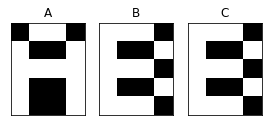

In [140]:
kwargs = {"update_type" : "asynchronous"}
getLetterOutput = lambda pattern_idx, args : letter_hopfield.runNetwork(noisy_letter_patterns[pattern_idx],
                                                                        **args).reshape((5,4))

letter_outputs = {'A': getLetterOutput(0, kwargs),
                  'B': getLetterOutput(1, kwargs),
                  'C': getLetterOutput(2, kwargs),
                  'D': getLetterOutput(3, kwargs),
                  'E': getLetterOutput(4, kwargs),
                  'F': getLetterOutput(5, kwargs),
                  'G': getLetterOutput(6, kwargs),
                  'H': getLetterOutput(7, kwargs)}

# Check similarity between predictions and expected patterns
percentage_same = calculateSimilarity([pred.flatten() for pred in np.array(list(letter_outputs.values())[:n_train_patterns])],
                                      letter_patterns[:n_train_patterns])
print(percentage_same)
print("Average percent identical: " + str(statistics.mean(percentage_same) * 100) + "%")

plotPatterns({k: letter_outputs[k] for k in list(letter_outputs)[:n_train_patterns]},
             1, n_train_patterns, file = "Hopfield/noisy_letters_3.pdf")

## Shape Patterns

[1.0, 1.0]
Average percent identical: 100.0%


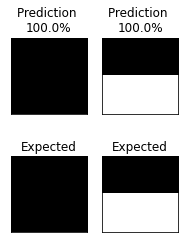

In [113]:
# Train network on binary patterns
first_train_pattern = 0
last_train_pattern = 2
n_train_patterns = last_train_pattern - first_train_pattern

binary_hopfield = Hopfield(binary_patterns[first_train_pattern:last_train_pattern], learning_rule = "s", dropout_rate = 0.4)

kwargs = {"update_type" : "asynchronous"}
getRandomOutput = lambda pattern_idx, args : binary_hopfield.runNetwork(noisy_binary_patterns[pattern_idx],
                                                                        **args)
# Get predictions
output_patterns = [getRandomOutput(0, kwargs)]

for i in range(1, n_train_patterns):
    output_patterns = np.vstack((output_patterns, getRandomOutput(i, kwargs)))
    
# Check similarity between predictions and expected patterns
percentage_same = calculateSimilarity(output_patterns, binary_patterns[first_train_pattern:last_train_pattern])
print(percentage_same)
print("Average percent identical: " + str(statistics.mean(percentage_same) * 100) + "%")
    
plotPatterns(np.vstack((output_patterns, binary_patterns[first_train_pattern:last_train_pattern])),
             num_row = 2, num_col = n_train_patterns,
             new_shape = pattern_size,
             subplot_titles = ["Prediction \n" + str(percentage_same[i] * 100) + "%" for i in range(n_train_patterns)] + ["Expected" for j in range(n_train_patterns)],
             file = "Hopfield/binary_patterns_dropout_20.pdf")

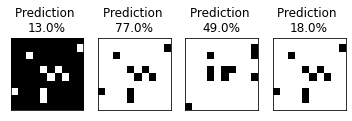

In [86]:
plotPatterns(output_patterns,
             num_row = 1, num_col = n_train_patterns,
             new_shape = pattern_size,
             subplot_titles = ["Prediction \n" + str(percentage_same[i] * 100) + "%" for i in range(n_train_patterns)],
             file = "Hopfield/binary_patterns_last_hebbian.pdf")